In [183]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.io import loadmat
from scipy.special import gamma
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.patches as patches
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [184]:
def embedding_fit_metrics(original_distances, embedded_distances):
    """
    Computes the following goodness-of-fit metrics for an embedding:
    1. Spearman's Rank Correlation
    2. Pearson Correlation
    3. R^2 value (MSE to the line y = x)

    Parameters:
    original_distances (array-like): Pairwise distances in the original space.
    embedded_distances (array-like): Pairwise distances in the embedded space.

    Returns:
    dict: A dictionary containing Spearman's rho, Pearson's r, and R^2 value.
    """
    
    # Ensure input is NumPy arrays
    original_distances = np.array(original_distances)
    embedded_distances = np.array(embedded_distances)
    
    # Compute Spearman's rank correlation
    spearman_corr, _ = spearmanr(original_distances, embedded_distances)
    
    # Compute Pearson correlation
    pearson_corr, _ = pearsonr(original_distances, embedded_distances)
    
    # Compute R^2 value (MSE to the line y = x)
    r2 = r2_score(original_distances, embedded_distances)
    
    return {
        "Spearman Rank Correlation": spearman_corr,
        "Pearson Correlation": pearson_corr,
        "R^2 Value": r2
    }

In [185]:
def vol(R, D):
    c = 2*np.power(np.pi, 0.5*D) 
    itg = integrate.quad(lambda x: np.power(np.sinh(x), D-1), 0.0, R)[0]
    return c*itg

def sample_r(R, D):
    rmin = 0.0; rmax = R; rc = 0.5*R
    V_tot = vol(R, D); uc = vol(rc, D)/V_tot
    u = np.random.uniform()
    while(np.abs(u-uc)>1e-4):
        if uc < u:
            rmin = rc
            rc = 0.5*(rc + rmax)
            uc = vol(rc, D)/V_tot
        elif u < uc:
            rmax = rc
            rc = 0.5*(rc + rmin)
            uc = vol(rc, D)/V_tot
    return rc

#uniformly sample a point in hyperbolic space out to Rmax
#return point in poincare coords
def h_samp(rm, D):
    direction = np.random.normal(size=D)
    direction = direction/np.sqrt(np.sum(np.square(direction)))
    #th = 2.0*np.pi*np.random.uniform()
    r_p = sample_r(rm, 2)
    return np.tanh(r_p/2.0)*direction
    #return np.tanh(r_p/2.0)*np.asarray([np.cos(th), np.sin(th)])

def pdist(p1, p2):
    inv = 2.0*(p1-p2).dot(p1-p2)/((1-p1.dot(p1))*(1-p2.dot(p2)))
    return np.arccosh(1.0 + inv)

In [186]:
class HMDS():
    def __init__(self, deltaij, D, a=2, b=0.5, sig_lam=10, tolerance=1e-10):
        ## Parameters ##
        self.deltaij = tf.constant(deltaij, dtype=tf.float32)
        self.N = tf.constant(deltaij.shape[0])
        self.D = tf.constant(D)

        ## Variables ##
        self.euc = tf.Variable(tf.random.normal(shape=(self.N, self.D), mean=0.0, stddev=.0001), dtype=tf.float32)
        self.log_sig = tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), dtype=tf.float32)
        self.log_lam = tf.Variable(0, dtype=tf.float32)

        ## Constraints ##
        self.time = tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), shape=(self.N,1), trainable=False)

        ## Model Hyperparameters ##
        self.a = a
        self.b = b
        self.sig_lam = sig_lam

        ## Optimization Hyperparameters ##
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self.tolerance = tolerance

        ## Optimization Results ##
        self.loss_curve = []
        self.lambda_curve = []
        
    @tf.function
    def constraint_time(self):
        return tf.expand_dims(tf.sqrt(tf.add(1.0,tf.square(tf.norm(self.euc,axis=1)))),1)

    @tf.function
    def pairwise_dist_lorentz(self):
        self.time = self.constraint_time()
        time_product = tf.matmul(self.time, self.time, transpose_b=True)
        space_product = tf.matmul(self.euc, self.euc, transpose_b=True)
        lorentzian_inner_product = time_product - space_product
        lorentzian_inner_product_clipped = tf.maximum(lorentzian_inner_product, 1.0+1e-7)
        distance_matrix = tf.math.acosh(lorentzian_inner_product_clipped) + 1e-12
        return distance_matrix
        
    @tf.function
    def loss(self):
        dist = self.pairwise_dist_lorentz()
        s2 = tf.transpose(tf.square(tf.math.exp(self.log_sig))) + tf.square(tf.math.exp(self.log_sig)) + 1e-12
        stress = tf.divide(tf.square(tf.divide(dist,tf.math.exp(self.log_lam)) - self.deltaij),s2)
        lkl = tf.add(stress, tf.math.log(tf.scalar_mul(2*np.pi, s2)))
        mask = tf.cast(tf.linalg.band_part(tf.ones_like(lkl),0, -1) - tf.eye(tf.shape(lkl)[0]), dtype=tf.bool)
        lkl_upper = tf.boolean_mask(lkl,mask)
        prior_lam = tf.scalar_mul(tf.divide(tf.cast(self.N*(self.N-1),tf.float32),4*(self.sig_lam**2)),tf.math.exp(self.log_lam)**2)
        prior_sig = tf.reduce_sum(tf.scalar_mul((self.a + 1), self.log_sig) + tf.divide(self.b, tf.math.exp(self.log_sig)))
        return 0.5*tf.reduce_sum(lkl_upper) + prior_lam + prior_sig + tf.reduce_sum(self.log_sig) + self.log_lam

    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            loss_value = self.loss()
        grads = tape.gradient(loss_value, [self.euc, self.log_sig, self.log_lam])
        self.optimizer.apply_gradients(zip(grads, [self.euc, self.log_sig, self.log_lam]))
        gradient_norm = tf.reduce_sum([tf.reduce_sum(tf.square(g)) for g in grads])
        return loss_value, gradient_norm

    def train(self, n=50000):
        for epoch in range(n):
            loss_val, gradient_norm = self.train_step()
            self.loss_curve.append(loss_val)
            self.lambda_curve.append(np.exp(self.log_lam.numpy()))
            if epoch % 5000 == 0:
                print(f'epoch {epoch}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}')
            if gradient_norm < self.tolerance:
                print(f"Converged at epoch {epoch + 1}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}")
                break  # Stop training

    ## Visualization ##
    def plot_loss(self):
        plt.figure()
        plt.plot(self.loss_curve)
        plt.xlabel('Step')
        plt.ylabel('-Log Likelihood')
        plt.show()

    def plot_lambda(self):
        plt.figure()
        plt.plot(self.lambda_curve)
        plt.xlabel('Step')
        plt.ylabel('Lambda')
        plt.show()

    def plot_sigmas(self):
        plt.figure()
        plt.hist(np.exp(self.log_sig.numpy()))
        plt.xlabel('Sigma')
        plt.ylabel('Counts')
        plt.show()

    def shepard(self):
        plt.figure()
        plt.scatter(self.deltaij.numpy()[np.triu_indices(self.N,k=1)], self.pairwise_dist_lorentz().numpy()[np.triu_indices(self.N,k=1)]/np.exp(self.log_lam))
        plt.xlabel('True Distance')
        plt.ylabel('Embedding Distance')
        plt.show()

    def get_poin(self):
        ts = np.sqrt(1.0 + np.sum(np.square(self.euc.numpy()), axis=1))
        p_coords = (self.euc.numpy().T / (ts + 1)).T
        return p_coords

    ## Metrics ##
    def MDS_lkl(self):
        lkl = 0
        dmat = self.deltaij.numpy()
        N = self.N.numpy()
        sigs = np.exp(self.log_sig.numpy())
        lam = np.exp(self.log_lam.numpy())
        emb_mat = self.pairwise_dist_lorentz().numpy()
        
        for i in np.arange(N):
            for j in np.arange(i+1, N):
                seff = sigs[i]**2 + sigs[j]**2
                lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi)
        return lkl[0]

    def BIC(self):
        N, D = self.N.numpy(), self.D.numpy()
        n = 0.5*N*(N-1)
        k = N*D + N + 1.0 - 0.5*D*(D-1)
        return float(k*np.log(n) + 2.0*self.MDS_lkl())

In [187]:
class nonmetricHMDS():
    def __init__(self, deltaij, D, Ns, a=2, b=0.5, sig_lam=10, sig_w=1, sig_b=10, sig_s=10,  tolerance=1e-10):
        ## Parameters ##
        self.deltaij = tf.constant(deltaij, dtype=tf.float32)
        self.N = tf.constant(deltaij.shape[0])
        self.D = tf.constant(D)
        self.Ns = tf.constant(Ns)

        ## Variables ##
        self.euc = tf.Variable(tf.random.normal(shape=(self.N, self.D), mean=0.0, stddev=.0001), dtype=tf.float32)
        self.log_sig =tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), dtype=tf.float32)
        self.log_w = tf.Variable(np.log(np.ones(self.Ns)/Ns), dtype=tf.float32)
        self.log_b = tf.Variable(tf.random.normal([self.Ns], mean=0, stddev=0.001), dtype=tf.float32)
        self.log_s = tf.Variable(np.log(np.linspace(1/self.Ns,1+1/self.Ns,self.Ns)), dtype=tf.float32)

        ## Constraints ##
        self.time = tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), shape=(self.N,1), trainable=False)

        ## Model Hyperparameters ##
        self.a = a
        self.b = b
        self.sig_w = sig_w
        self.sig_b = sig_b
        self.sig_s = sig_s

        ## Optimization Hyperparameters ##
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.tolerance = tolerance

        ## Optimization Results ##
        self.loss_curve = []

    @tf.function
    def constraint_time(self):
        return tf.expand_dims(tf.sqrt(tf.add(1.0,tf.square(tf.norm(self.euc,axis=1)))),1)

    @tf.function
    def pairwise_dist_lorentz(self):
        self.time = self.constraint_time()
        time_product = tf.matmul(self.time, self.time, transpose_b=True)
        space_product = tf.matmul(self.euc, self.euc, transpose_b=True)
        lorentzian_inner_product = time_product - space_product
        lorentzian_inner_product_clipped = tf.maximum(lorentzian_inner_product, 1.0+1e-7)
        distance_matrix = tf.math.acosh(lorentzian_inner_product_clipped) + 1e-12
        return distance_matrix

    @tf.function
    def sigmoid(self,x):
        return tf.math.sigmoid(4*x)

    @tf.function
    def monotonic(self,x):
        dist_s = tf.expand_dims(x, axis=-1) - tf.math.exp(tf.expand_dims(self.log_s, axis=0))
        dist_bs = tf.multiply(dist_s,tf.math.exp(tf.expand_dims(self.log_b, axis=0)))
        sig = self.sigmoid(dist_bs)
        transformed_dist = tf.multiply(sig,tf.math.exp(tf.expand_dims(self.log_w, axis=0)))
        return tf.reduce_sum(transformed_dist, axis=-1)
        
    @tf.function
    def loss(self):
        dist = self.pairwise_dist_lorentz()
        trans_dist =  self.monotonic(dist)
        s2 = tf.transpose(tf.square(tf.math.exp(self.log_sig))) + tf.square(tf.math.exp(self.log_sig)) + 1e-12
        stress = tf.divide(tf.square(trans_dist - self.deltaij),s2)
        lkl = tf.add(stress, tf.math.log(tf.scalar_mul(2*np.pi, s2)))
        mask = tf.cast(tf.linalg.band_part(tf.ones_like(lkl),0, -1) - tf.eye(tf.shape(lkl)[0]), dtype=tf.bool)
        lkl_upper = tf.boolean_mask(lkl,mask)
        prior_sig = tf.reduce_sum(tf.scalar_mul((self.a + 1), self.log_sig) + tf.divide(self.b, tf.math.exp(self.log_sig)))
        return 0.5*tf.reduce_sum(lkl_upper) + prior_sig + tf.reduce_sum(self.log_sig) + tf.reduce_sum(self.log_w) + tf.reduce_sum(self.log_b) + tf.reduce_sum(self.log_s)# + self.log_lam + prior_lam + 

    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            loss_value = self.loss()
        grads = tape.gradient(loss_value, [self.euc, self.log_sig, self.log_w, self.log_b, self.log_s])
        self.optimizer.apply_gradients(zip(grads, [self.euc, self.log_sig, self.log_w, self.log_b, self.log_s]))
        gradient_norm = tf.reduce_sum([tf.reduce_sum(tf.square(g)) for g in grads])
        return loss_value, gradient_norm

    def train(self, n=50000):
        self.plot_transformation()
        for epoch in range(n):
            loss_val, gradient_norm = self.train_step()
            self.loss_curve.append(loss_val)
            if epoch % 5000 == 0:
                print(f'epoch {epoch}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}')
            if gradient_norm < self.tolerance:
                print(f"Converged at epoch {epoch + 1}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}")
                break  # Stop training

    ## Visualization ##
    def plot_loss(self):
        plt.figure()
        plt.plot(self.loss_curve)
        plt.xlabel('Step')
        plt.ylabel('-Log Likelihood')
        plt.show()

    def plot_transformation(self):
        plt.figure()
        maxDist = np.max(self.pairwise_dist_lorentz().numpy())
        x = np.linspace(0-5,maxDist+10,100,dtype=np.float32)
        plt.plot(x,self.monotonic(x))
        plt.vlines(maxDist,0,self.monotonic(maxDist),linestyles='dashed',color='red')
        plt.xlabel('Input Distance')
        plt.ylabel('Output Distance')
        plt.show()

    def plot_sigmas(self):
        plt.figure()
        plt.hist(np.exp(self.log_sig.numpy()))
        plt.xlabel('Sigma')
        plt.ylabel('Counts')
        plt.show()

    def shepard(self):
        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        ax[0].scatter(self.deltaij.numpy()[np.triu_indices(self.N,k=1)], self.pairwise_dist_lorentz().numpy()[np.triu_indices(self.N,k=1)])
        ax[0].set_xlabel('True Distance')
        ax[0].set_ylabel('Embedding Distance')
        ax[1].scatter(self.deltaij.numpy()[np.triu_indices(self.N,k=1)], self.monotonic(self.pairwise_dist_lorentz()).numpy()[np.triu_indices(self.N,k=1)])
        ax[1].plot([0,1],[0,1],linestyle='--')
        ax[1].set_xlabel('True Distance')
        ax[1].set_ylabel('Transformed Embedding Distance')
        plt.show()

    def get_poin(self):
        ts = np.sqrt(1.0 + np.sum(np.square(self.euc.numpy()), axis=1))
        p_coords = (self.euc.numpy().T / (ts + 1)).T
        return p_coords
    
    def MDS_lkl(self):
        lkl = 0
        dmat = self.deltaij.numpy()                             # Original dissimilarities δᵢⱼ
        N = self.N.numpy()
        sigs = np.exp(self.log_sig.numpy())                     # σᵢ values
        emb_mat = self.pairwise_dist_lorentz().numpy()          # Raw hyperbolic distances
        transformed = self.monotonic(emb_mat).numpy()           # f(dᵢⱼ)

        for i in np.arange(N):
            for j in np.arange(i+1, N):
                seff = sigs[i]**2 + sigs[j]**2 + 1e-12           # σᵢ² + σⱼ²
                diff = dmat[i][j] - transformed[i][j]            # δᵢⱼ - f(dᵢⱼ)
                lkl += (diff**2 / (2.0 * seff)) + 0.5 * np.log(seff * 2.0 * np.pi)

        return lkl

    def BIC(self):
        N = self.N.numpy()
        D = self.D.numpy()
        Ns = self.Ns.numpy()
        n = 0.5 * N * (N - 1)                         # Number of pairwise observations

        # Number of parameters:
        # - N * D       : embedding coordinates
        # - N           : uncertainty values (log_sig)
        # - 3 * Ns      : parameters for f(x): log_w, log_b, log_s
        k = N * D + N + 3 * Ns

        # Negative log-likelihood using monotonic f(x)
        lkl = self.MDS_lkl()

        # Bayesian Information Criterion
        BIC = k * np.log(n) + 2 * lkl
        return float(BIC)


'''
    ## Metrics ##
    def MDS_lkl(self):
        lkl = 0
        dmat = self.deltaij.numpy()               # Original dissimilarities
        N = self.N.numpy()
        sigs = np.exp(self.log_sig.numpy())       # Uncertainty per point (σᵢ)
        lam = np.exp(self.log_lam.numpy())        # Curvature scale (λ)
        emb_mat = self.pairwise_dist_lorentz().numpy()   # Hyperbolic distances
        
        for i in np.arange(N):      # Loop Over Upper Triangle of Distance Matrix
            for j in np.arange(i+1, N):     
                seff = sigs[i]**2 + sigs[j]**2
                lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi) # This is the negative log-likelihood for a normal distribution,,, so we are assuming delta_ij belongs to normal dist which is a metric assumption?
        return lkl[0] # isn't lkl a scalar? it should return just lkl

    def BIC(self):
        N, D = self.N.numpy(), self.D.numpy()
        n = 0.5*N*(N-1)
        k = N*D + N + 1.0 - 0.5*D*(D-1)
        return float(k*np.log(n) + 2.0*self.MDS_lkl())
'''



"\n    ## Metrics ##\n    def MDS_lkl(self):\n        lkl = 0\n        dmat = self.deltaij.numpy()               # Original dissimilarities\n        N = self.N.numpy()\n        sigs = np.exp(self.log_sig.numpy())       # Uncertainty per point (σᵢ)\n        lam = np.exp(self.log_lam.numpy())        # Curvature scale (λ)\n        emb_mat = self.pairwise_dist_lorentz().numpy()   # Hyperbolic distances\n        \n        for i in np.arange(N):      # Loop Over Upper Triangle of Distance Matrix\n            for j in np.arange(i+1, N):     \n                seff = sigs[i]**2 + sigs[j]**2\n                lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi) # This is the negative log-likelihood for a normal distribution,,, so we are assuming delta_ij belongs to normal dist which is a metric assumption?\n        return lkl[0] # isn't lkl a scalar? it should return just lkl\n\n    def BIC(self):\n        N, D = self.N.numpy(), self.D.numpy()\n        n = 0.5*N*

In [188]:
N = 100
pts = np.asarray([h_samp(0.05, 3) for i in np.arange(N)])
print(pts.shape)
dmat = np.zeros((100,100))

for i in np.arange(100):
    for j in np.arange(i+1, 100):
        dmat[i][j] = pdist(pts[i], pts[j])
        dmat[j][i] = dmat[i][j]

dmat = dmat #+ 0.1*np.random.normal(size=(100,100))

dmat = dmat/np.max(dmat)
#dmat = np.arcsin(dmat) # deliberately violate the properties of a metric (like the triangle inequality) — because real-world data often doesn't obey perfect metric assumptions.
#dmat = np.sin((np.pi/2)*dmat)
dmat = dmat/np.max(dmat)
# Use arcsin to get strong curvature-like effects while preserving smoothness and rank. and controlled range. 
## It's convex on [0, 1], meaning small distances get expanded more than large ones. 

(100, 3)


(array([ 79., 336., 718., 925., 978., 825., 595., 291., 160.,  43.]),
 array([0.01832835, 0.11649552, 0.21466268, 0.31282985, 0.41099701,
        0.50916418, 0.60733134, 0.70549851, 0.80366567, 0.90183284,
        1.        ]),
 <BarContainer object of 10 artists>)

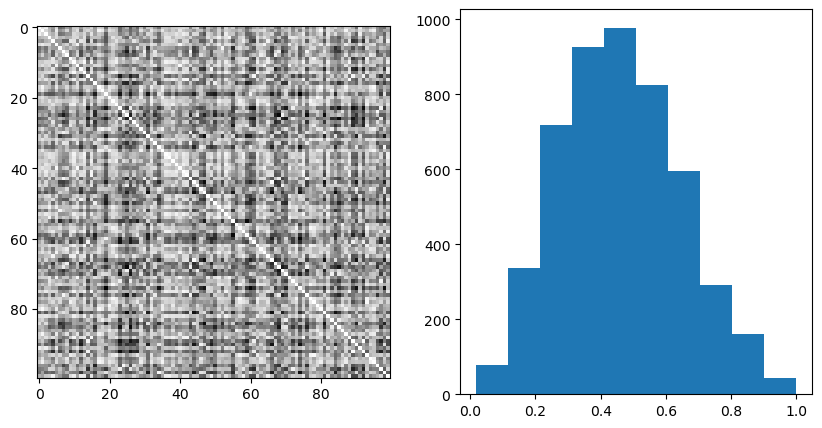

In [189]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(dmat, cmap='Greys')
ax[1].hist(dmat[np.triu_indices(N,k=1)])

In [190]:
testnmHMDS = nonmetricHMDS(dmat,3,3)

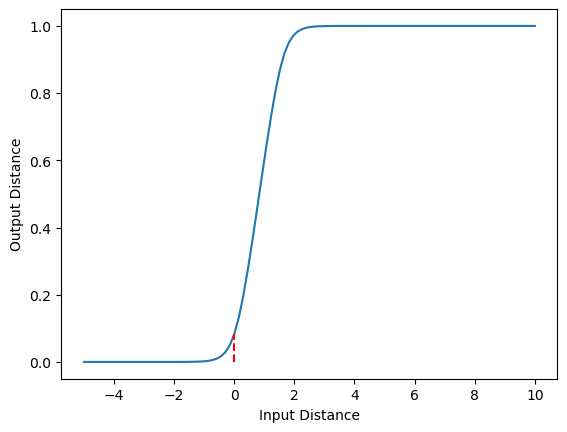

epoch 0, Loss: 6528.51171875, normG: 253469.703125
epoch 5000, Loss: -13103.7978515625, normG: 25288.060546875
epoch 10000, Loss: -13336.4609375, normG: 3450.0810546875
epoch 15000, Loss: -13352.265625, normG: 1134.992431640625
epoch 20000, Loss: -13358.6630859375, normG: 1686665.75
epoch 25000, Loss: -13362.228515625, normG: 4124.5927734375
epoch 30000, Loss: -13364.2802734375, normG: 1129674.5
epoch 35000, Loss: -13365.3818359375, normG: 6791471.0
25.501198053359985


In [191]:
now = time.time()
testnmHMDS.train(n=40000)
print(time.time() - now)

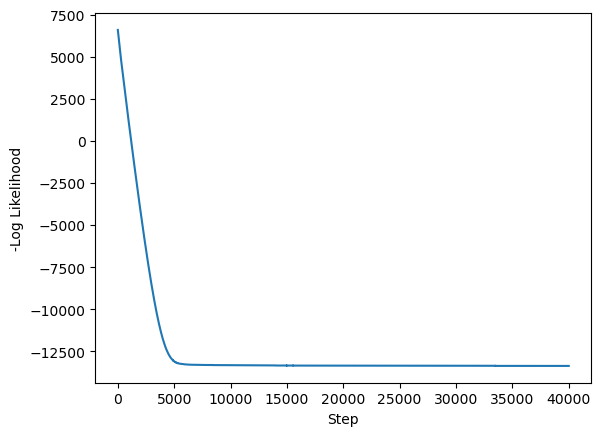

In [89]:
testnmHMDS.plot_loss()

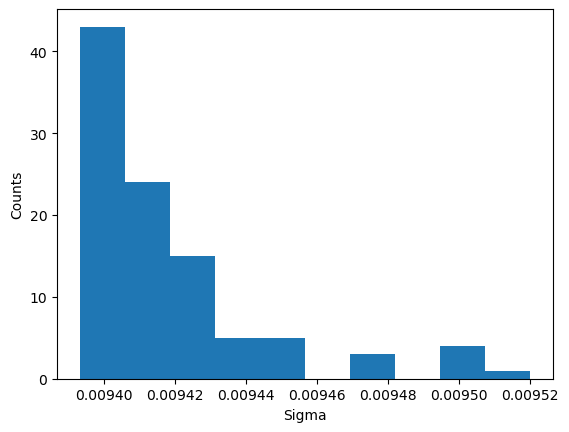

In [90]:
testnmHMDS.plot_sigmas()

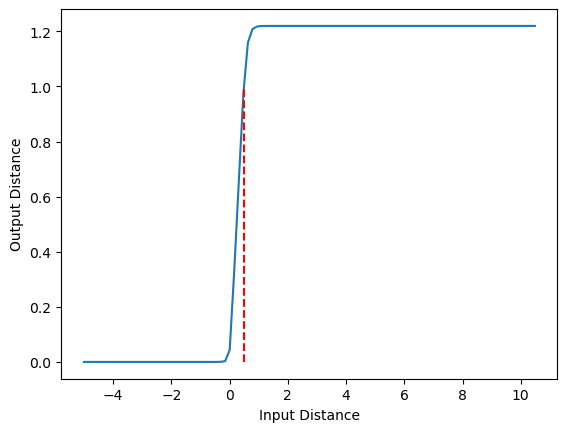

In [91]:
testnmHMDS.plot_transformation()

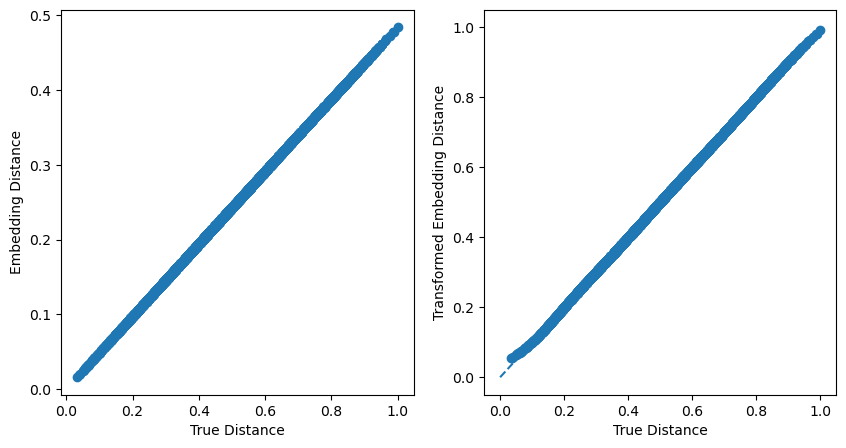

In [92]:
testnmHMDS.shepard()

(100, 3)


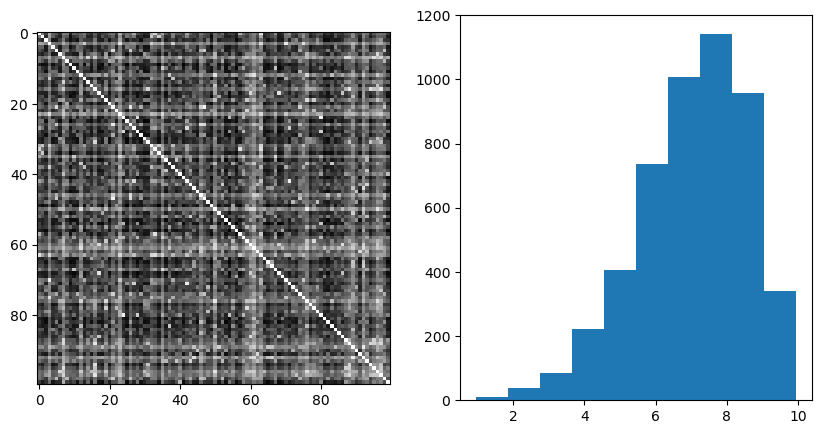

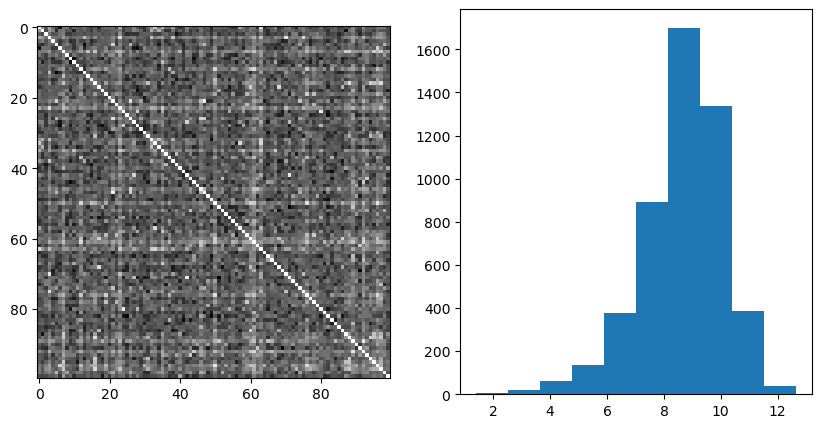

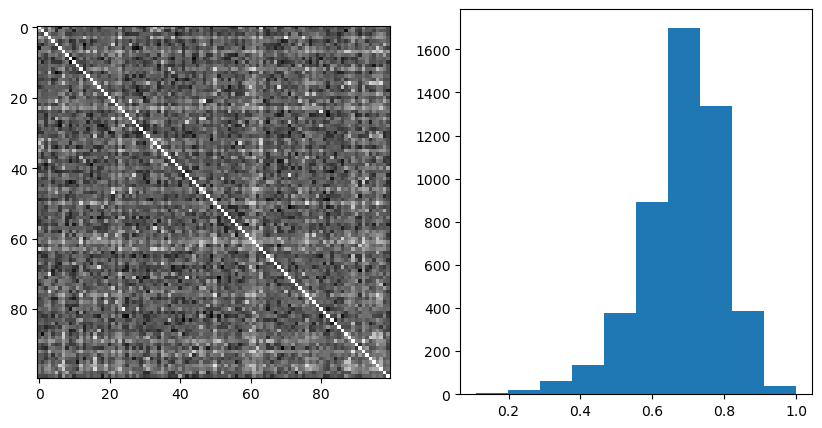

In [175]:
N = 100
pts = np.asarray([h_samp(5.0, 3) for i in np.arange(N)])
print(pts.shape)
dmat = np.zeros((N,N))

for i in np.arange(N):
    for j in np.arange(i+1, N):
        dmat[i][j] = pdist(pts[i], pts[j])
        dmat[j][i] = dmat[i][j]
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(dmat, cmap='Greys')
ax[1].hist(dmat[np.triu_indices(N,k=1)])
plt.show()

Noisy_dmat = np.zeros((N,N))
for i in np.arange(N):
    for j in np.arange(i+1, N):
        Noisy_dmat[i][j] = Noisy_dmat[j][i] = dmat[i][j]
        #if dmat[i,j] >= 6:
        Noisy_dmat[i][j] = 10*np.sin((np.pi/20)*(dmat[i][j]))+np.random.normal(0,dmat[i][j]/10)
        #Noisy_dmat[i][j] = dmat[i][j] + np.random.normal(0,1/(dmat[i][j]/0.5))
        Noisy_dmat[j][i] = Noisy_dmat[i][j]

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(Noisy_dmat, cmap='Greys')
ax[1].hist(Noisy_dmat[np.triu_indices(N,k=1)])
plt.show()
        
#dmat = dmat + 0.1*np.random.normal(size=(100,100))
Noisy_dmat = Noisy_dmat/np.max(Noisy_dmat)

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(Noisy_dmat, cmap='Greys')
ax[1].hist(Noisy_dmat[np.triu_indices(N,k=1)])
plt.show()

### shouldn't we use a Use a multivariate Gaussian noise model for truly correlated noise? this is heteroscedastic!

Only perturb very large distances
why are long range relationships considered less reliable here but local ones are trusted?

isn't it better to normalize first and then dmat[i,j] > 0.8,, or prolly unnecessary on second thought oops

but in neural data, distance can't be fuzzy right? the point has to be fuzzy. so if point i is fuzzy then d_ij and d_ik both need to be fuzzy regardless of is the distance is large or small. so I don't think this is a good way to inject noise into our synthetic data if we are evaluating our model robustness for potential neural data. Ask Anoop?Milo?
Or try to figure out myself>>?

if dmat[i,j] >= 100:
is never triggered — your hyperbolic distances are always small.

(array([  8.,  15.,  31.,  67., 149., 198., 266., 275., 175.,  41.]),
 array([0.1785744 , 0.2580806 , 0.3375868 , 0.41709299, 0.49659919,
        0.57610539, 0.65561158, 0.73511778, 0.81462398, 0.89413017,
        0.97363637]),
 <BarContainer object of 10 artists>)

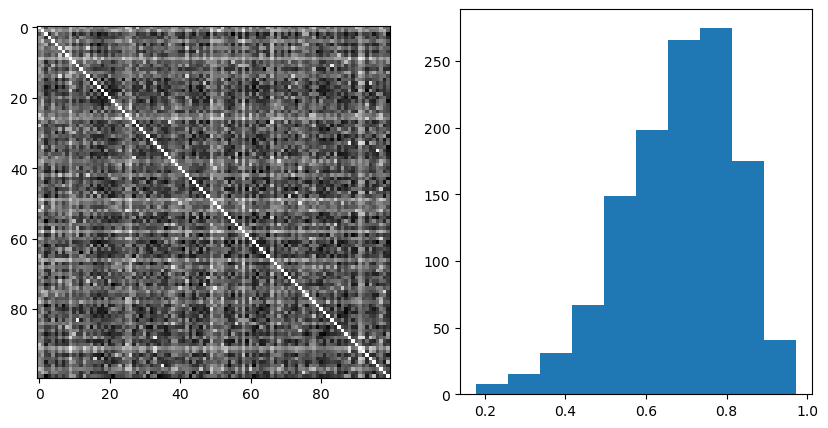

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(Noisy_dmat, cmap='Greys')
ax[1].hist(Noisy_dmat[np.triu_indices(50,k=1)])

In [135]:
testnmHMDS = nonmetricHMDS(dmat,3,10)

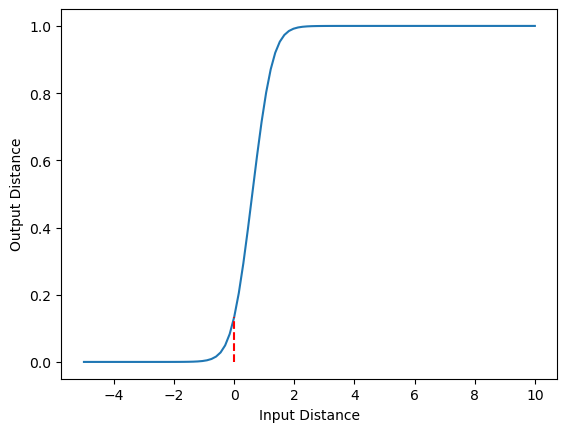

epoch 0, Loss: 6691.017578125, normG: 217499.484375
epoch 5000, Loss: -8483.359375, normG: 990.7098388671875
epoch 10000, Loss: -9042.9072265625, normG: 4883.60498046875
epoch 15000, Loss: -9399.47265625, normG: 2649.49365234375
epoch 20000, Loss: -9644.80078125, normG: 4440.251953125
epoch 25000, Loss: -9834.8173828125, normG: 17636.75
24.409202098846436


In [136]:
now = time.time()
testnmHMDS.train(n=30000)
print(time.time() - now)

normG = Total Gradient Norm = is the sum of squared gradients of all learnable parameter : Track how "steep" the loss surface is
when normG is small, gradients are vanishing → training is stabilizing

?? tuning learning rate or improving initialization could help ??

For negative log loss I'm summing over N Choose 2 ~ 4950 pairs

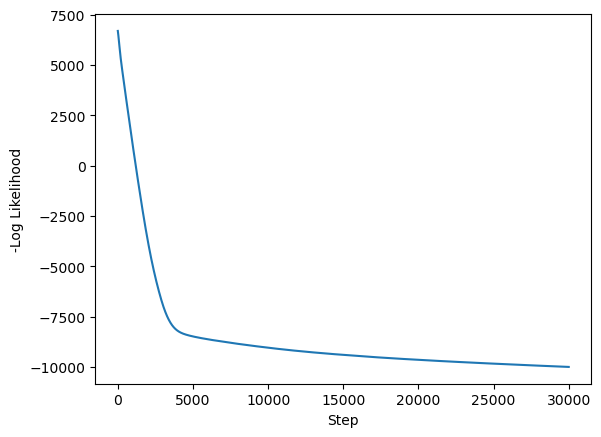

In [137]:
testnmHMDS.plot_loss()

why did this plateau for so many steps in between?

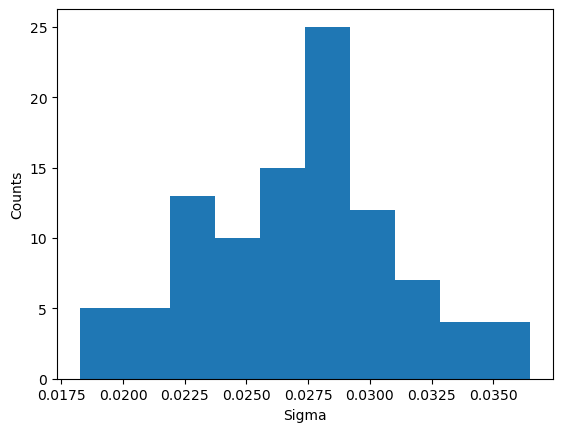

In [138]:
testnmHMDS.plot_sigmas()

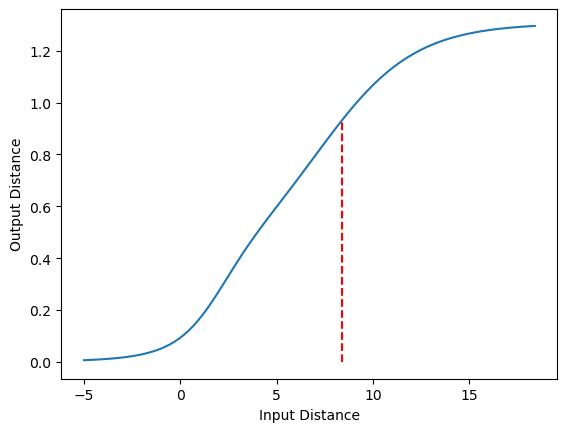

In [139]:
testnmHMDS.plot_transformation()

function must be smooth, no?

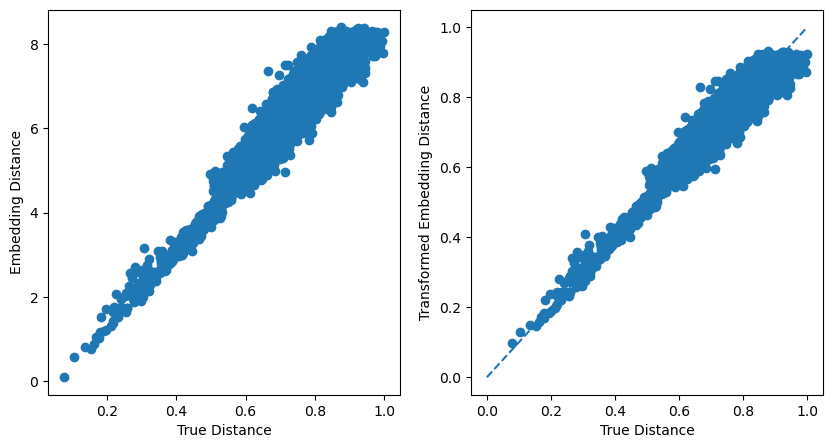

In [140]:
testnmHMDS.shepard()

I should make the above onotonic function plot for the normalized input distance instead of the true input distance because then I will be able to match the kinks to the flat lines in the shepard diagram of transformed distances to the monotonic functon graph

no but the flat lines can't be due to the monotonic funciton because I can see those flat lines in the untransformed embedding distance ka graph as well

a variety of true distances are being fit to the same embedding distances

In [22]:
nmHMDS = nonmetricHMDS(dmat,3,3)

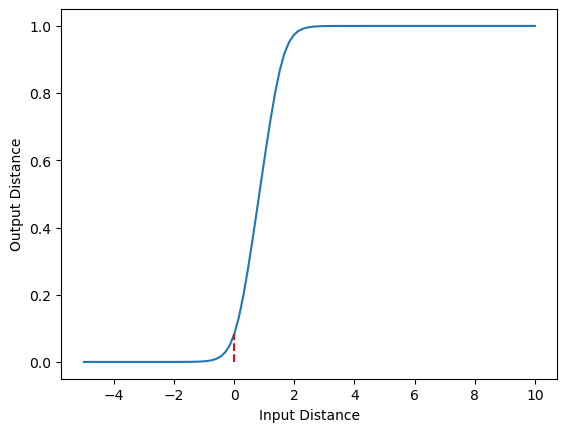

epoch 0, Loss: 71693.4296875, normG: 172549648.0
epoch 5000, Loss: 6870.1083984375, normG: 80854.8515625
epoch 10000, Loss: -3546.0400390625, normG: 13290470.0
epoch 15000, Loss: -5689.55078125, normG: 105738752.0
epoch 20000, Loss: -6822.4443359375, normG: 1239416.25
epoch 25000, Loss: -7612.982421875, normG: 4988733.0
epoch 30000, Loss: -8235.271484375, normG: 181701472.0
epoch 35000, Loss: -8816.3544921875, normG: 71573320.0
epoch 40000, Loss: -9351.2431640625, normG: 5083753.0
epoch 45000, Loss: -9800.447265625, normG: 990300.1875
34.27154803276062


In [23]:
now = time.time()
nmHMDS.train(n=50000)
print(time.time() - now)

This plot shows the initial learned monotonic transformation f(x), which maps raw hyperbolic distances d_ij  to predicted dissimilarities δ_ij
Was generated by plot_transformation funciton
X-axis = input distances from the embedding
Y-axis = output distances = transformed distances via your learned function
The blue curve is your model’s current f(x)
This is using only 2 steps N_s = 2, and weights are equal = 0.5, and default initialization is near 0,, therefore I get something close to f(x) ~ sigmoid(x)

Red line tells: My training data only contains distances up to this point -- but I don't really understand that!
Everything to the right of this line is extrapolation — the model is learning f(x) beyond the domain it sees
As training progresses: The steps in f(x) (controlled by log_w, log_b, log_s) will move around.

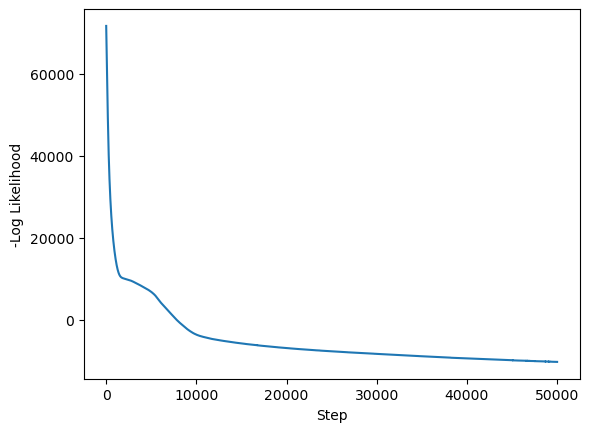

In [24]:
nmHMDS.plot_loss()

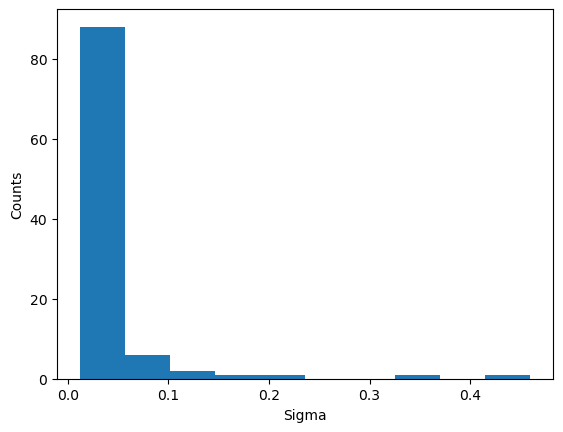

In [25]:
nmHMDS.plot_sigmas()

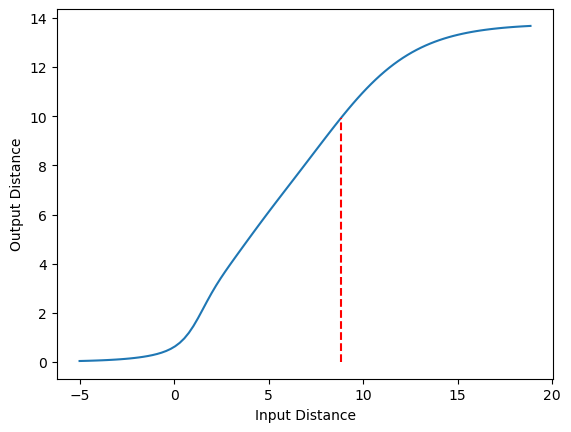

In [26]:
nmHMDS.plot_transformation()

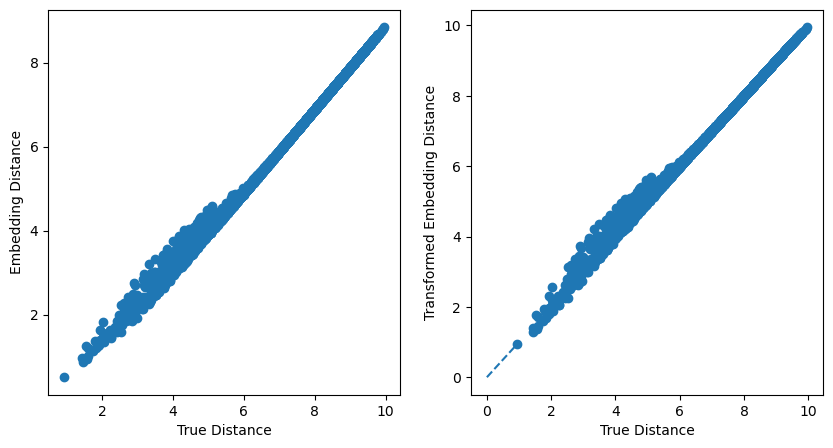

In [27]:
nmHMDS.shepard()

In [28]:
nmHMDS = nonmetricHMDS(dmat,3,5)

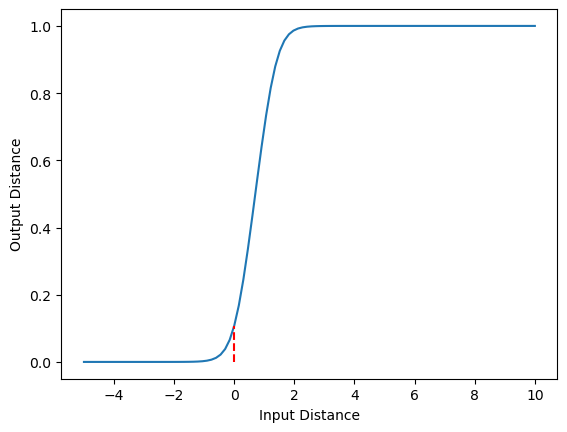

epoch 0, Loss: 71211.3046875, normG: 168474656.0
epoch 5000, Loss: 8569.3681640625, normG: 16708.91796875
epoch 10000, Loss: -1249.3446044921875, normG: 33762.56640625
epoch 15000, Loss: -4105.93359375, normG: 11234504.0
epoch 20000, Loss: -5636.9716796875, normG: 74962664.0
epoch 25000, Loss: -6585.3916015625, normG: 22068.36328125
epoch 30000, Loss: -7369.6298828125, normG: 651855872.0
epoch 35000, Loss: -7757.33642578125, normG: 480992.125
epoch 40000, Loss: -8176.74658203125, normG: 121205184.0
epoch 45000, Loss: -8634.23046875, normG: 7949174.5
32.040194034576416


In [29]:
now = time.time()
nmHMDS.train(n=50000)
print(time.time() - now)

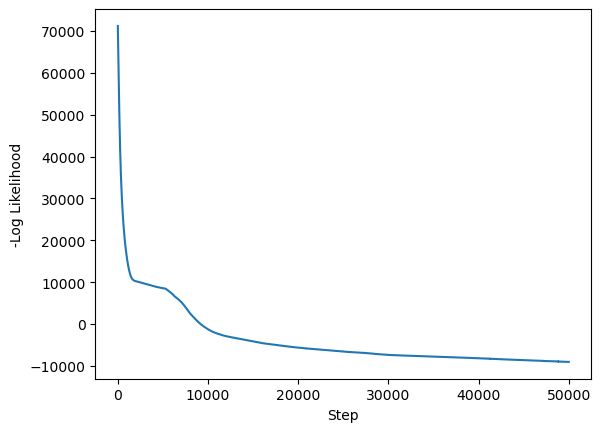

In [30]:
nmHMDS.plot_loss()

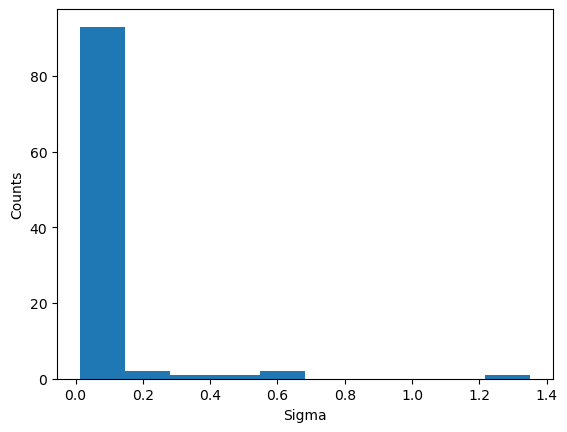

In [31]:
nmHMDS.plot_sigmas()

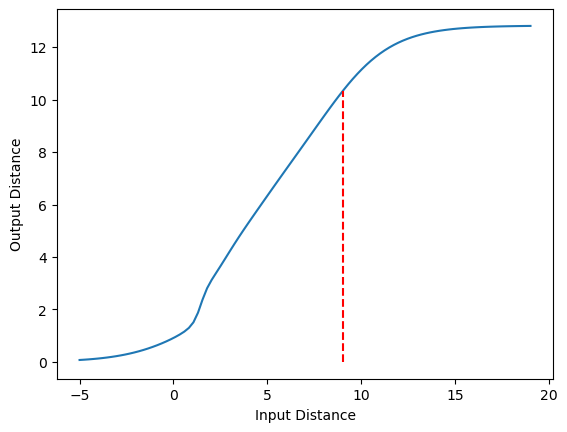

In [32]:
nmHMDS.plot_transformation()

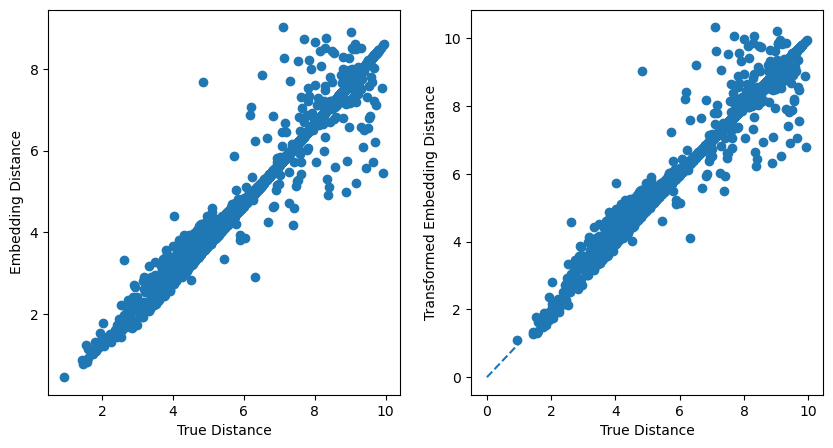

In [33]:
nmHMDS.shepard()

In [176]:
nmHMDS_noisy = nonmetricHMDS(Noisy_dmat,3,5)

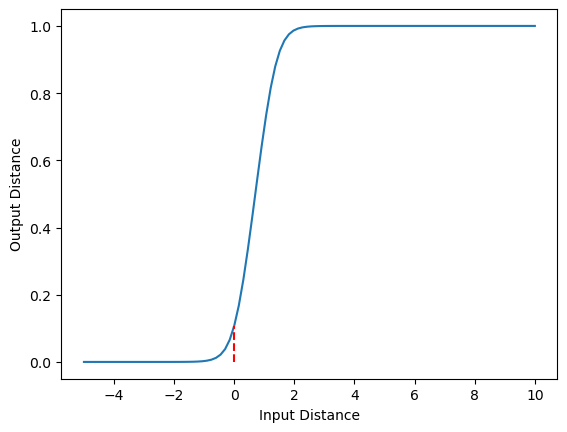

epoch 0, Loss: 6731.8095703125, normG: 225536.09375
epoch 5000, Loss: -7017.34033203125, normG: 1549.967529296875
epoch 10000, Loss: -7304.27978515625, normG: 38.25944519042969
epoch 15000, Loss: -7417.11669921875, normG: 305.7203369140625
epoch 20000, Loss: -7499.7744140625, normG: 1236.51513671875
epoch 25000, Loss: -7561.5419921875, normG: 66.68109130859375
18.384406089782715


In [177]:
now = time.time()
nmHMDS_noisy.train(n=30000)
print(time.time() - now)

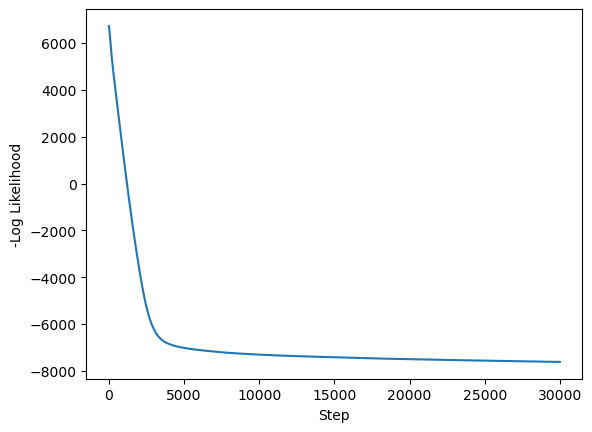

In [178]:
nmHMDS_noisy.plot_loss()

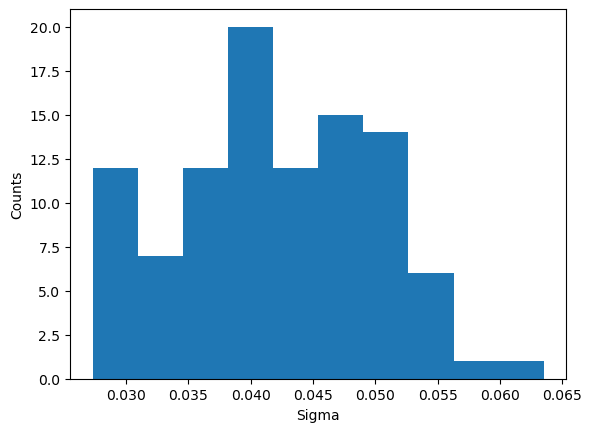

In [179]:
nmHMDS_noisy.plot_sigmas()

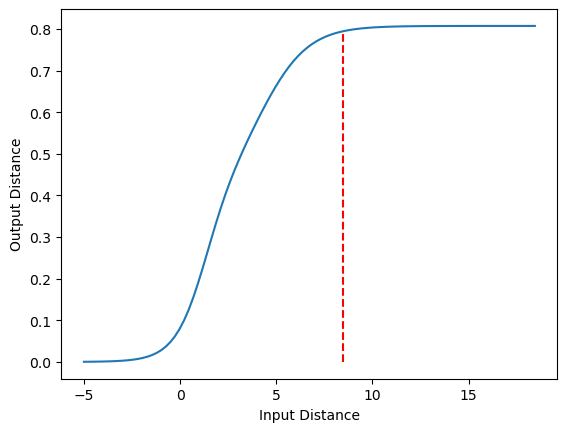

In [180]:
nmHMDS_noisy.plot_transformation()

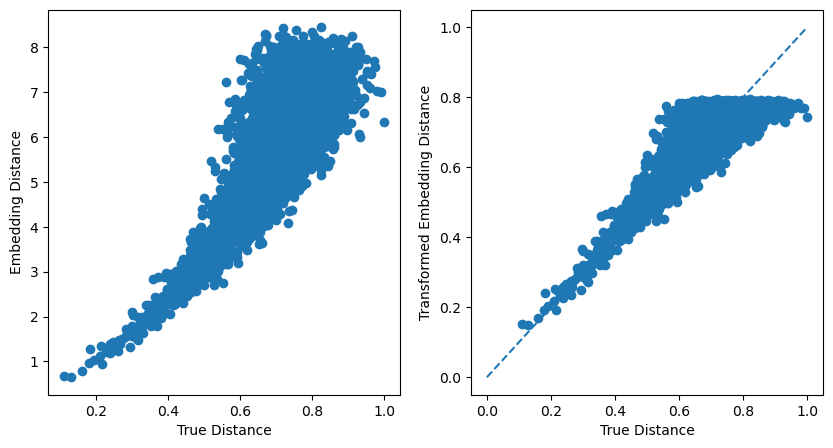

In [181]:
nmHMDS_noisy.shepard()

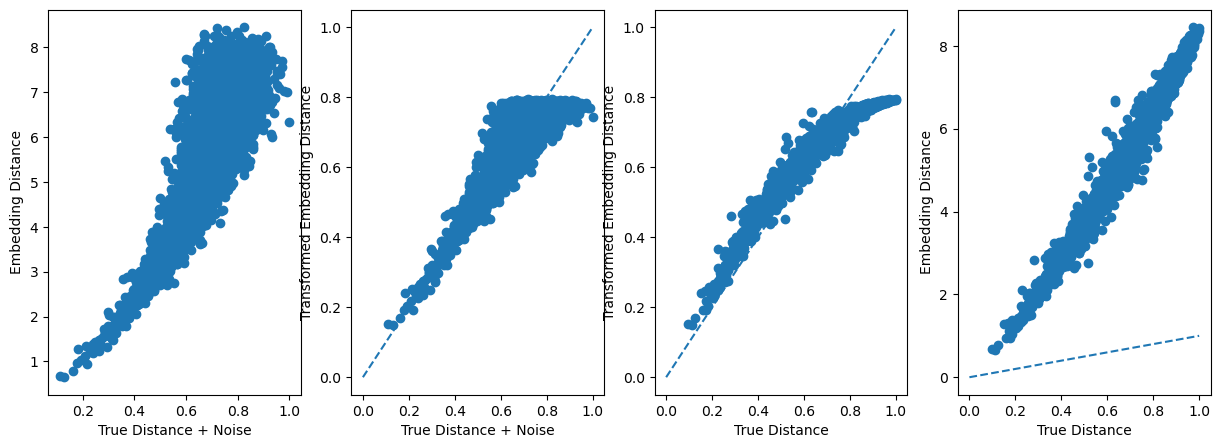

In [182]:
dmat = dmat/np.max(dmat)
fig, ax = plt.subplots(1, 4, figsize=(15,5))
ax[0].scatter(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])
ax[0].set_xlabel('True Distance + Noise')
ax[0].set_ylabel('Embedding Distance')
ax[1].scatter(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])
ax[1].plot([0,1],[0,1],linestyle='--')
ax[1].set_xlabel('True Distance + Noise')
ax[1].set_ylabel('Transformed Embedding Distance')
ax[2].scatter(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])
ax[2].plot([0,1],[0,1],linestyle='--')
ax[2].set_xlabel('True Distance')
ax[2].set_ylabel('Transformed Embedding Distance')
ax[3].scatter(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], (nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])
ax[3].plot([0,1],[0,1],linestyle='--')
ax[3].set_xlabel('True Distance')
ax[3].set_ylabel('Embedding Distance')
plt.show()

In [41]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.9999552465932896,
 'Pearson Correlation': 0.9998869410860705,
 'R^2 Value': -1473.6618867926068}

In [42]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.9999552465932896,
 'Pearson Correlation': 0.999911069859777,
 'R^2 Value': 0.9998217066470464}

In [43]:
embedding_fit_metrics(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.9999552465932896,
 'Pearson Correlation': 0.999911069859777,
 'R^2 Value': 0.9998217066470464}

In [44]:
nmHMDS_noisy = nonmetricHMDS(Noisy_dmat,3,5)

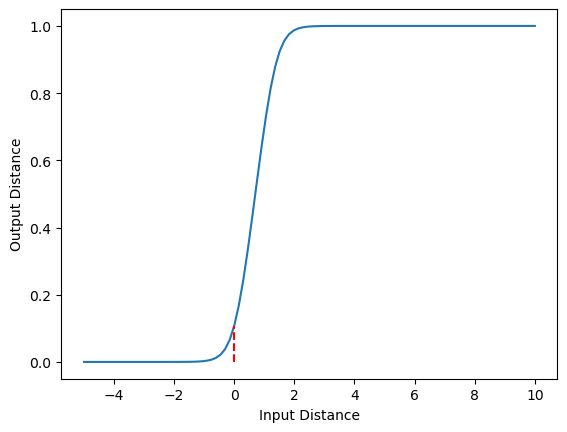

epoch 0, Loss: 6798.685546875, normG: 217779.71875
epoch 5000, Loss: -9807.0224609375, normG: 8039.9794921875
epoch 10000, Loss: -11109.8623046875, normG: 1618.182373046875
epoch 15000, Loss: -11815.296875, normG: 9010.150390625
epoch 20000, Loss: -12288.6494140625, normG: 30481.712890625
epoch 25000, Loss: -12623.755859375, normG: 530.5490112304688
epoch 30000, Loss: -12872.4443359375, normG: 144407.9375
epoch 35000, Loss: -13067.4443359375, normG: 33894.203125
epoch 40000, Loss: -13228.0419921875, normG: 966.504150390625
epoch 45000, Loss: -13360.025390625, normG: 49.97932434082031
34.260643005371094


In [45]:
now = time.time()
nmHMDS_noisy.train(n=50000)
print(time.time() - now)

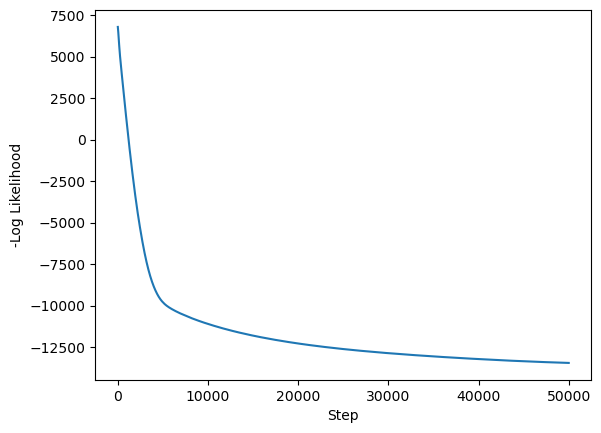

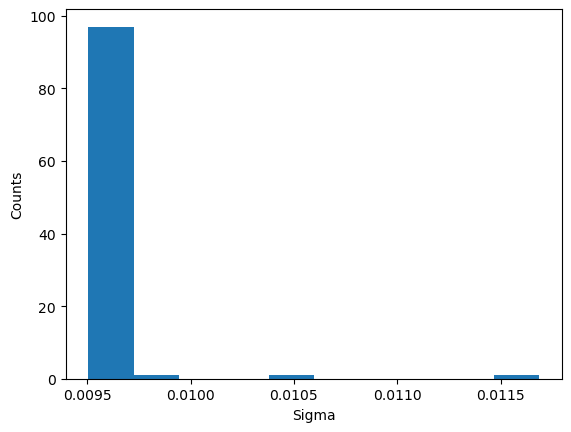

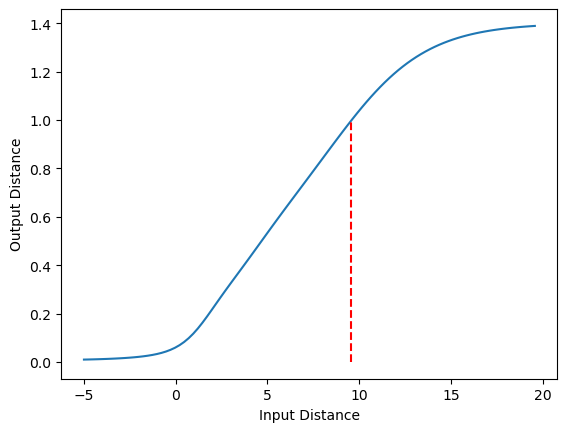

In [46]:
nmHMDS_noisy.plot_loss()
nmHMDS_noisy.plot_sigmas()
nmHMDS_noisy.plot_transformation()

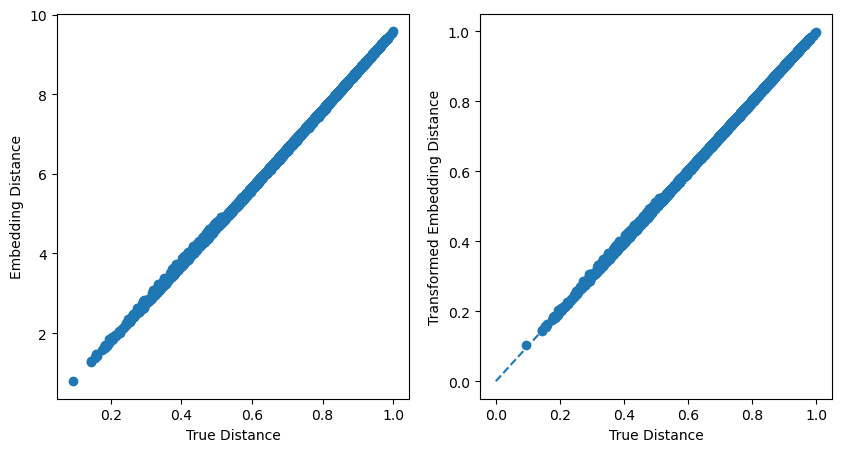

In [47]:
nmHMDS_noisy.shepard()

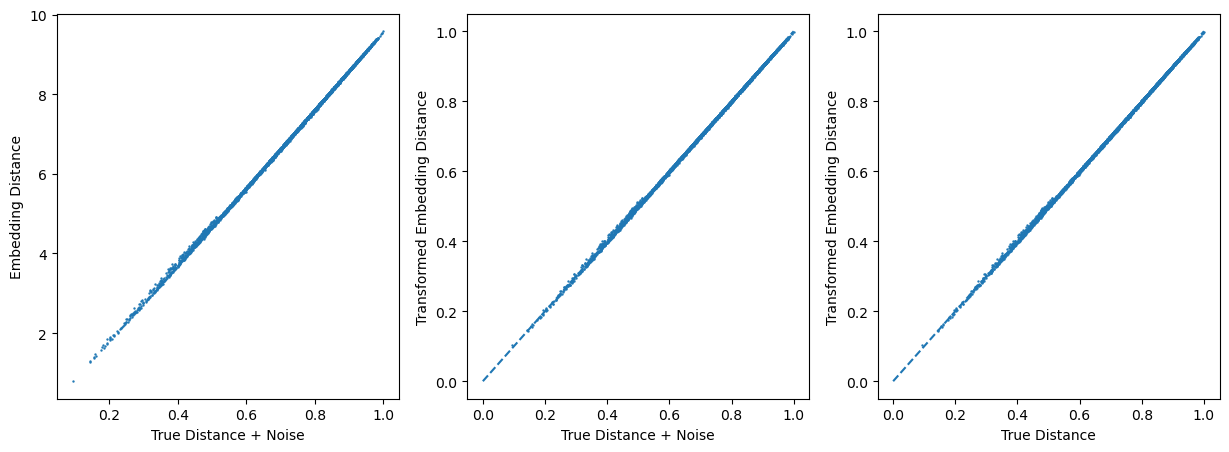

In [48]:
dmat = dmat/np.max(dmat)
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].scatter(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)],s=0.5)
ax[0].set_xlabel('True Distance + Noise')
ax[0].set_ylabel('Embedding Distance')
ax[1].scatter(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)],s=0.5)
ax[1].plot([0,1],[0,1],linestyle='--')
ax[1].set_xlabel('True Distance + Noise')
ax[1].set_ylabel('Transformed Embedding Distance')
ax[2].scatter(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)],s=0.5)
ax[2].plot([0,1],[0,1],linestyle='--')
ax[2].set_xlabel('True Distance')
ax[2].set_ylabel('Transformed Embedding Distance')
plt.show()

In [49]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.9999527940296038,
 'Pearson Correlation': 0.9998803329378056,
 'R^2 Value': -1469.4627536630308}

In [50]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.9999527940296038,
 'Pearson Correlation': 0.9999057751772407,
 'R^2 Value': 0.9998112666518488}

In [51]:
embedding_fit_metrics(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.9999527940296038,
 'Pearson Correlation': 0.9999057751772407,
 'R^2 Value': 0.9998112666518488}

In [52]:
HMDS_noisy = HMDS(Noisy_dmat,3)

In [53]:
now = time.time()
HMDS_noisy.train(n=50000)
print(time.time() - now)

epoch 0, Loss: 7011.17236328125, normG: 160164.203125
epoch 5000, Loss: 3766.841064453125, normG: 245486.546875
epoch 10000, Loss: 1186.0792236328125, normG: 233338.8125
epoch 15000, Loss: -1025.1907958984375, normG: 171627.09375
epoch 20000, Loss: -2746.14111328125, normG: 156778.84375
epoch 25000, Loss: -3994.123291015625, normG: 112586.828125
epoch 30000, Loss: -4643.38525390625, normG: 18675.04296875
epoch 35000, Loss: -5043.3046875, normG: 11870.9375
epoch 40000, Loss: -5349.02880859375, normG: 9650.2802734375
epoch 45000, Loss: -5618.5625, normG: 8166.76904296875
20.267008066177368


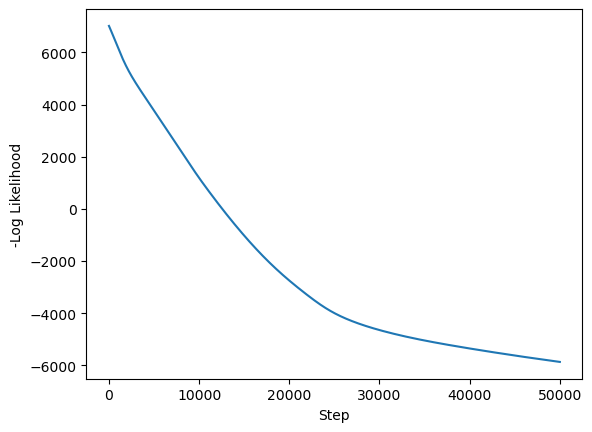

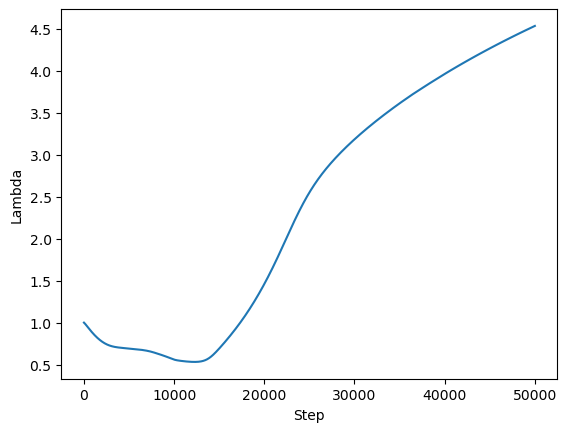

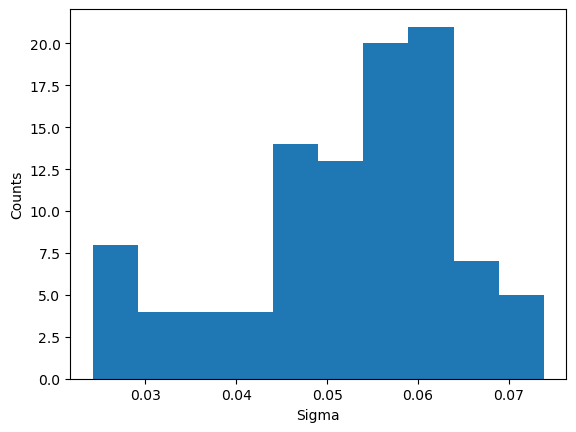

In [54]:
HMDS_noisy.plot_loss()
HMDS_noisy.plot_lambda()
HMDS_noisy.plot_sigmas()

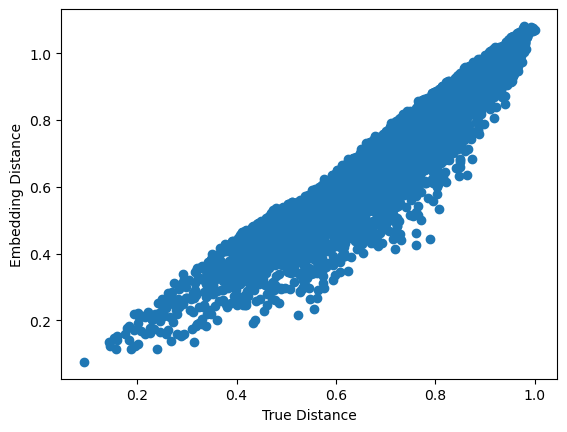

In [55]:
HMDS_noisy.shepard()

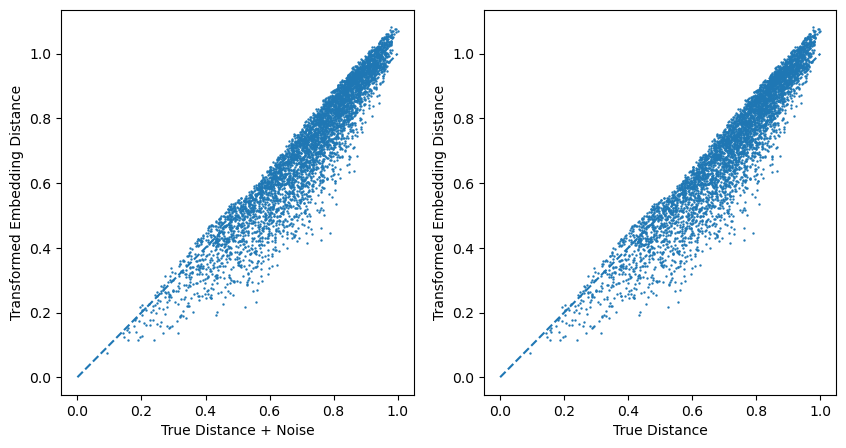

In [56]:
dmat = dmat/np.max(dmat)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].scatter(Noisy_dmat[np.triu_indices(HMDS_noisy.N,k=1)], HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam),s=0.5)
ax[0].plot([0,1],[0,1],linestyle='--')
ax[0].set_xlabel('True Distance + Noise')
ax[0].set_ylabel('Transformed Embedding Distance')
ax[1].scatter(dmat[np.triu_indices(HMDS_noisy.N,k=1)], HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam),s=0.5)
ax[1].plot([0,1],[0,1],linestyle='--')
ax[1].set_xlabel('True Distance')
ax[1].set_ylabel('Transformed Embedding Distance')
plt.show()

In [57]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(HMDS_noisy.N,k=1)],HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam))

{'Spearman Rank Correlation': 0.9490949605502412,
 'Pearson Correlation': 0.9432688455658309,
 'R^2 Value': 0.8008014666678265}

In [58]:
embedding_fit_metrics(dmat[np.triu_indices(HMDS_noisy.N,k=1)],HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam))

{'Spearman Rank Correlation': 0.9490949605502412,
 'Pearson Correlation': 0.9432688455658309,
 'R^2 Value': 0.8008014666678265}

In [59]:
nmHMDS_noisy = nonmetricHMDS(Noisy_dmat,3,5)

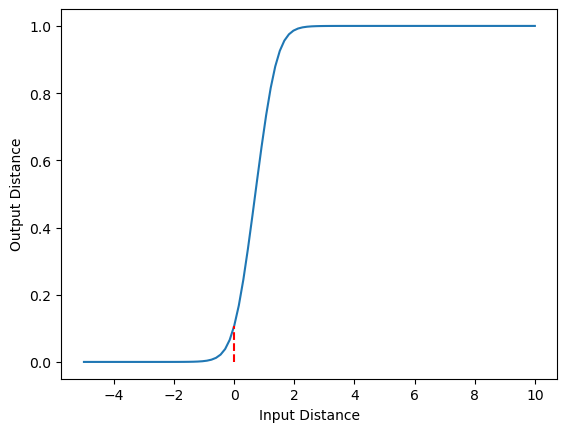

epoch 0, Loss: 6798.19677734375, normG: 217776.0625
epoch 5000, Loss: -9777.60546875, normG: 8093.97216796875
epoch 10000, Loss: -11064.583984375, normG: 19680.923828125
epoch 15000, Loss: -11794.783203125, normG: 24466.97265625
epoch 20000, Loss: -12275.791015625, normG: 3215799.5
epoch 25000, Loss: -12615.12109375, normG: 2146.5302734375
epoch 30000, Loss: -12866.1015625, normG: 57192.171875
epoch 35000, Loss: -13062.3828125, normG: 2103008.5
epoch 40000, Loss: -13224.1279296875, normG: 585.1905517578125
epoch 45000, Loss: -13357.1259765625, normG: 752.6224365234375
40.7672598361969


In [60]:
now = time.time()
nmHMDS_noisy.train(n=50000)
print(time.time() - now)

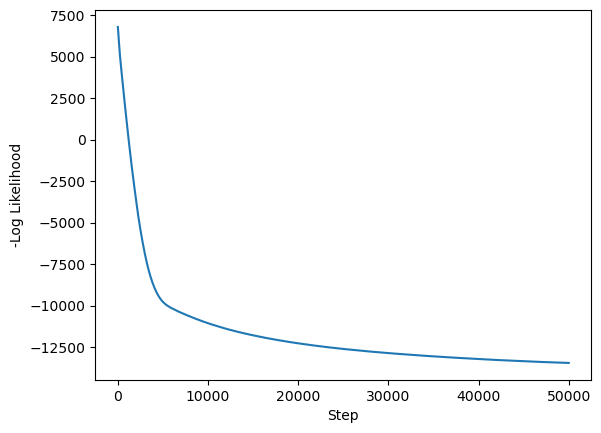

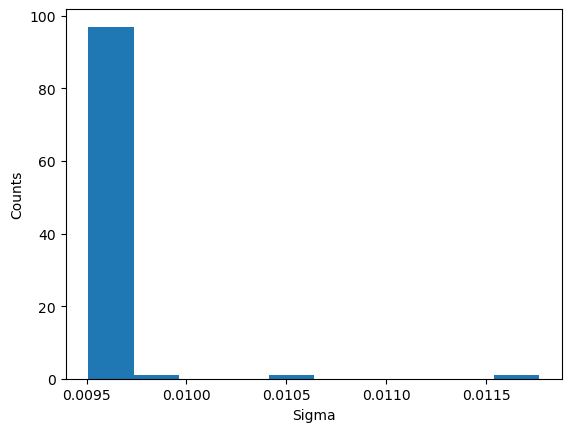

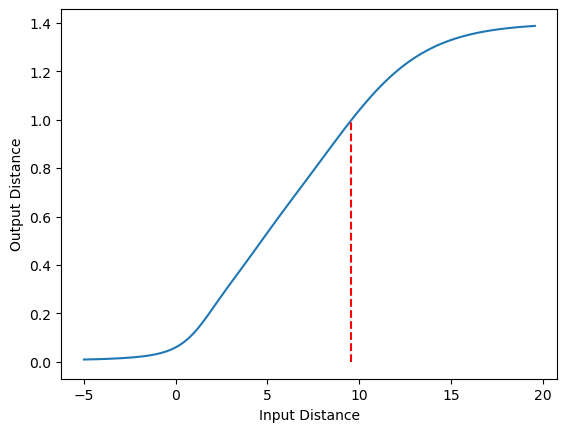

In [61]:
nmHMDS_noisy.plot_loss()
nmHMDS_noisy.plot_sigmas()
nmHMDS_noisy.plot_transformation()

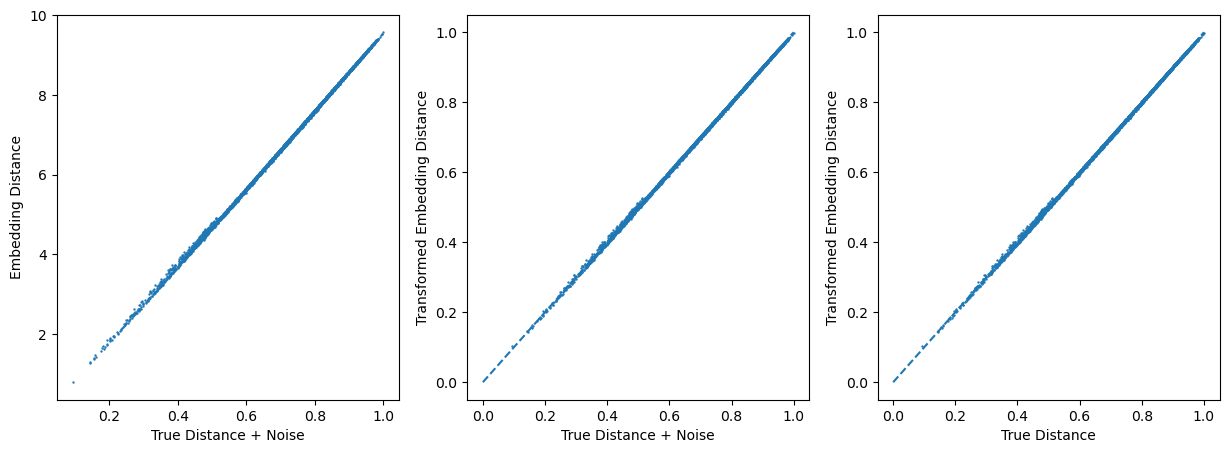

In [62]:
dmat = dmat/np.max(dmat)
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].scatter(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)],s=0.5)
ax[0].set_xlabel('True Distance + Noise')
ax[0].set_ylabel('Embedding Distance')
ax[1].scatter(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)],s=0.5)
ax[1].plot([0,1],[0,1],linestyle='--')
ax[1].set_xlabel('True Distance + Noise')
ax[1].set_ylabel('Transformed Embedding Distance')
ax[2].scatter(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)],s=0.5)
ax[2].plot([0,1],[0,1],linestyle='--')
ax[2].set_xlabel('True Distance')
ax[2].set_ylabel('Transformed Embedding Distance')
plt.show()

In [63]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.9999516207664665,
 'Pearson Correlation': 0.9998770919049205,
 'R^2 Value': -1467.2120208067906}

In [64]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.9999516224731534,
 'Pearson Correlation': 0.9999034517797285,
 'R^2 Value': 0.9998066089382909}

In [65]:
embedding_fit_metrics(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.9999516224731534,
 'Pearson Correlation': 0.9999034517797285,
 'R^2 Value': 0.9998066089382909}

In [66]:
HMDS_noisy = HMDS(Noisy_dmat,3)

In [67]:
now = time.time()
HMDS_noisy.train(n=50000)
print(time.time() - now)

epoch 0, Loss: 7010.701171875, normG: 160143.0625
epoch 5000, Loss: 3777.722900390625, normG: 243314.421875
epoch 10000, Loss: 1184.9007568359375, normG: 233175.5625
epoch 15000, Loss: -1025.508056640625, normG: 171464.1875
epoch 20000, Loss: -2741.606201171875, normG: 153497.875
epoch 25000, Loss: -3998.99169921875, normG: 140093.34375
epoch 30000, Loss: -4660.12353515625, normG: 17114.2578125
epoch 35000, Loss: -5062.5126953125, normG: 10710.3017578125
epoch 40000, Loss: -5367.88671875, normG: 8826.419921875
epoch 45000, Loss: -5636.30322265625, normG: 7538.36279296875
19.43265700340271


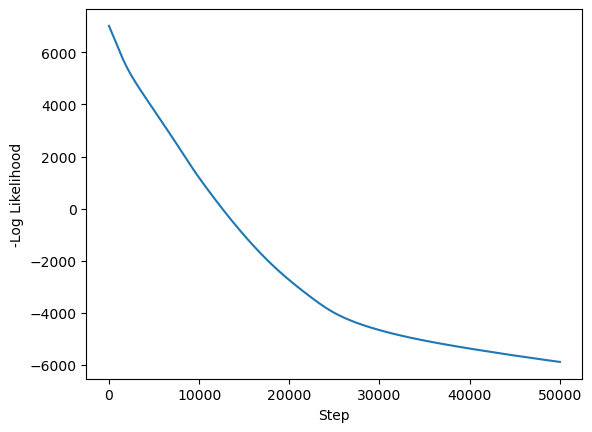

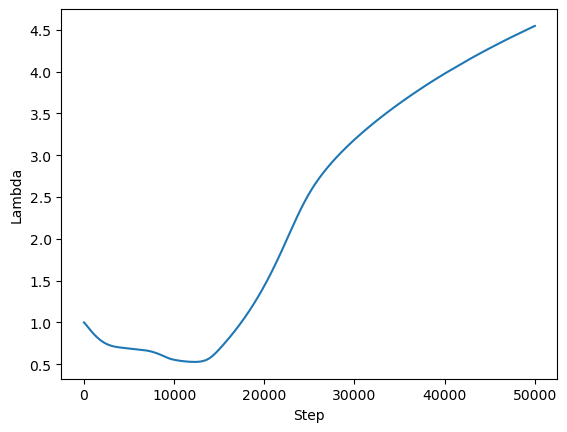

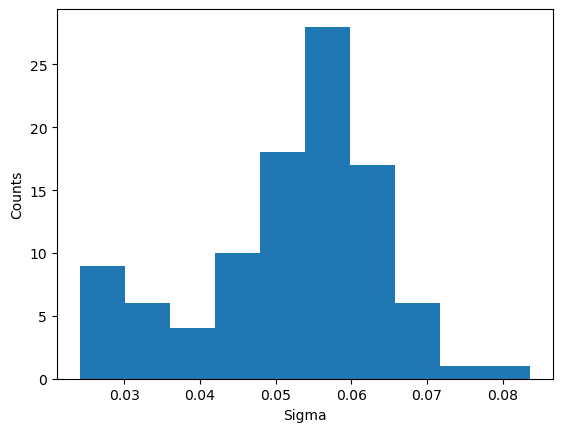

In [68]:
HMDS_noisy.plot_loss()
HMDS_noisy.plot_lambda()
HMDS_noisy.plot_sigmas()

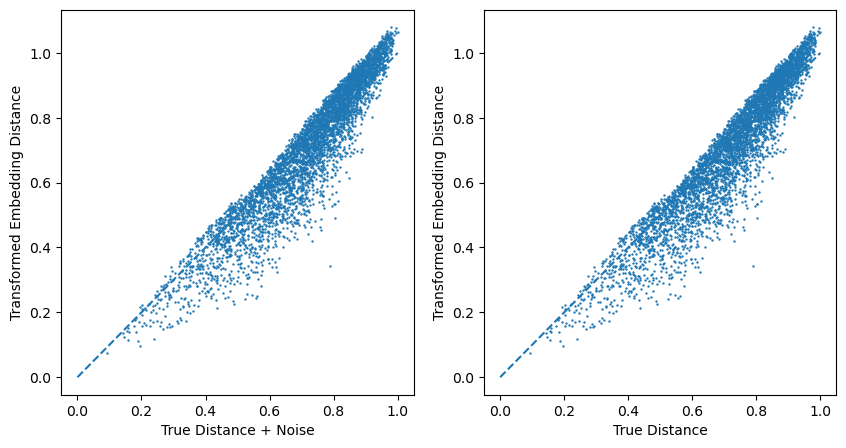

In [69]:
dmat = dmat/np.max(dmat)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].scatter(Noisy_dmat[np.triu_indices(HMDS_noisy.N,k=1)], HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam),s=0.5)
ax[0].plot([0,1],[0,1],linestyle='--')
ax[0].set_xlabel('True Distance + Noise')
ax[0].set_ylabel('Transformed Embedding Distance')
ax[1].scatter(dmat[np.triu_indices(HMDS_noisy.N,k=1)], HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam),s=0.5)
ax[1].plot([0,1],[0,1],linestyle='--')
ax[1].set_xlabel('True Distance')
ax[1].set_ylabel('Transformed Embedding Distance')
plt.show()

In [70]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(HMDS_noisy.N,k=1)],HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam))

{'Spearman Rank Correlation': 0.9485827297030852,
 'Pearson Correlation': 0.9431295797299912,
 'R^2 Value': 0.8018731966346124}

In [71]:
embedding_fit_metrics(dmat[np.triu_indices(HMDS_noisy.N,k=1)],HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam))

{'Spearman Rank Correlation': 0.9485827297030852,
 'Pearson Correlation': 0.9431295797299912,
 'R^2 Value': 0.8018731966346124}